# Fastai Learner

In the previous notebooks we've seen how to create Datasets and Dataloaders.
Now we will try to wrap everything together to create a learner.

In [1]:
%load_ext autoreload
%autoreload 2

from waternet.wndataset import WNDataSet
from fastai.vision.all import *


### Creating the Datasets

In [2]:
# default config for shape, size and step
config = dict(
    shape=(5490, 5490),
    patch_size=(512, 512),
    step=262,    
)

# 2018 october for training
train_ds = WNDataSet.from_masks(
    masks_path='d:/temp/22KEV/',
    pattern='*20181*.tif',
    **config
)

# a single image for the validation
valid_ds = WNDataSet.from_masks(
    masks_path='d:/temp/22KEV/',
    pattern='*20210221T133219*.tif',
    **config
)

train_ds.bands = ['B11', 'B12']
valid_ds.bands = ['B11', 'B12']

print(train_ds)
print(valid_ds)

Matching imgs/masks:   0%|          | 0/11 [00:00<?, ?it/s]

Matching imgs/masks:   0%|          | 0/1 [00:00<?, ?it/s]

WNDataset instance with 11 images
Loaded: 0 items
Empty: 11 items
Loading: 0 items

WNDataset instance with 1 images
Loaded: 0 items
Empty: 1 items
Loading: 0 items



If we try to access one item, without proper initialization...

### Creating Dataloaders

In [3]:
# Create two dataloaders (for training and validation)
# Put it in the GPU
dls = DataLoaders(
    DataLoader(train_ds, bs=4),
    DataLoader(valid_ds, bs=4)
)

In [4]:
m, t = dls.valid.one_batch()
m.device

device(type='cpu')

In [5]:
dls.train.one_batch()[1].shape

Loading image 1 in background


torch.Size([4, 512, 512])

### Creating the Learner

In [6]:
import pdb
def loss_fn(pred, targ):
    return torch.nn.functional.cross_entropy(pred, targ.squeeze(1).type(torch.long))

# CrossEntropyLossFlat(axis=1)

In [7]:
learner = unet_learner(dls, arch=resnet18, normalize=False, n_in=2, n_out=3, loss_func=loss_fn)
# cuda_model = learner.cuda()

d:\Programs\miniconda3\envs\fastai\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
d:\Programs\miniconda3\envs\fastai\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Checking model and predictions

In [10]:
learner.summary()

DynamicUnet (Input shape: 4 x 2 x 512 x 512)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 64 x 256 x 256  
Conv2d                                    6272       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     4 x 64 x 128 x 128  
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                      

In [19]:
batch, target = dls.train.one_batch()
print(batch.shape, target.shape)

Cleared image 10
Loading image 1 in background
torch.Size([4, 2, 512, 512]) torch.Size([4, 512, 512])


In [14]:
# Calculate the predictions for the 4 patches (1 batch)
pred = learner.model(batch)
pred.shape

torch.Size([4, 3, 512, 512])

In [17]:
loss_fn(pred, target)

TensorBase(0.9572, grad_fn=<AliasBackward0>)

In [20]:
CrossEntropyLossFlat(axis=1)(pred, target)

TensorBase(0.9572, grad_fn=<AliasBackward0>)

### Running LrFind

Up to now, evertying was done in the CPU, but to run large amounts, it is necessary to load the data in the Cuda device. For that we will put them in the GPU and find the best learning rate.

In [8]:
learner.cuda()
learner.dls = dls.cuda()

Loaded sucessfully


SuggestedLRs(valley=0.00010964782268274575)

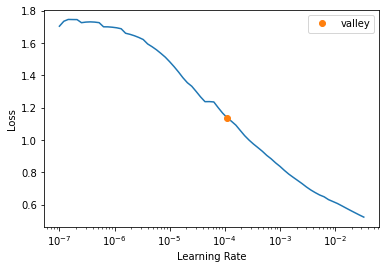

In [9]:
learner.lr_find()

In [10]:
learner.fit_one_cycle(1, lr_max=0.0001)

epoch,train_loss,valid_loss,time
0,0.163114,0.382699,15:14


Cleared image 0
Loading image 2 in background
Loaded sucessfully
Cleared image 1
Loading image 3 in background
Loaded sucessfully
Cleared image 2
Loading image 4 in background
Loaded sucessfully
Cleared image 3
Loading image 5 in background
Loaded sucessfully
Cleared image 4
Loading image 6 in background
Loaded sucessfully
Cleared image 5
Loading image 7 in background
Loaded sucessfully
Cleared image 6
Loading image 8 in background
Loaded sucessfully
Cleared image 7
Loading image 9 in background
Loaded sucessfully
Cleared image 8
Loading image 10 in background
Loaded sucessfully
Cleared image 9
Loading image 0 in background
Loaded sucessfully


In [13]:
learner.model_dir

'models'

In [14]:
learner.save('first_model')

Path('models/first_model.pth')

### Como ver os resultados???

In [ ]:
learner